# 1 Setup

## Notebook Config

In [1]:
# Standard library imports
import sys
import os

# GCP library imports
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from google.oauth2 import service_account

# Third-party library imports
from datetime import date, datetime, timedelta
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import IsolationForest
import shap
import numpy as np
# from pandas_gbq import read_gbq

# Custom utility imports
from aggelos_libraries import *

/opt/conda/envs/aiFraud/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set project id
PROJECT_ID = "research-1049"

# Set BQ dataset where results will be saved
DESTINATION_DATASET = "WINSON_TEST"

# Set environment variables
os.environ["PROJECT_ID"] = PROJECT_ID
# os.environ["GOOGLE_APPLICATION_CREDENTIALS_R"] = "../winson/google_compute_engine_research.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS_P"] = "../winson/google_compute_engine_prd.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../winson/google_compute_engine_prd_health.json"

print(f"Project: {PROJECT_ID}, Dataset: {DESTINATION_DATASET}")

Project: research-1049, Dataset: WINSON_TEST


## Dataset Initialisation

In [3]:
# Variables

# today's date
DATE = (datetime.now() - timedelta(days=2)).strftime('%Y%m%d')
START_DATE = DATE
END_DATE = DATE

print(f"Date: {DATE}")
print(f"Start Date: {START_DATE}")
print(f"End Date: {END_DATE}")

# exactly one month ago from today
one_month_ago = datetime.now() - relativedelta(months=1) - timedelta(days=2)
LAST_MONTH_DATE = one_month_ago.strftime('%Y%m%d')
LAST_MONTH = one_month_ago.strftime('%Y%m')

print(f"Last Month Date: {LAST_MONTH_DATE}")
print(f"Last Month: {LAST_MONTH}")

Date: 20250614
Start Date: 20250614
End Date: 20250614
Last Month Date: 20250514
Last Month: 202505


In [4]:
# clients
CLIENT_LIST = ['AA','ACL','ACM','ACX','ADKA','ADL','ADM','ADMO','ADVL','AGX','AIO',
    'AML','AMTY','AMW','AOX','APL','AR','ATM','AV','AWGM','AWMG','AXS',
    'BAT','BC','BCB','BD','BDU','BF','BIGO','BLS','BMX','BRC','BRM','BRV',
    'BSH','BW','BZ','BZK','CDG','CERT','CIMA','CMC','CMN','CMX','CO','CPX',
    #'CTM',
    'CW','DA','DECA','DGF','DMM','DOM','DRS','EP','EX','EXNS','FAD',
    'FCP','FF',
    #'FK',
    'FTT','FTVF','GA',#'GGM',
    'GMS','GSM','GTA','GWG',#'GWM',
    'HDM','HST','IAB','IBT','IGM','INB','INS','IQZ','ISM',#'KBT',
    'KDOO','KK',
    'KRM','KT','KWI','LDA','LM','LPD','LS','LTV','LUNA','MBC','MBF','MBT',
    'MCM','MF','MGID','MKT','ML',#'MLM',
    'MLX','MNX','MOBI','MOBU','MTK','MTO',
    'MX','MYF',#'NAD','NGG','NR','NXV',
    'OCT','OHM','OPR','OPX','OTAD','OWN',
    'PBM','PD','PHO','PIXALATE','PKL','PKT','PMA','PMS','PN','PPC','PPG',
    'PUBC','PX','QU','RM','RO','SA','SCTY','SFBT','SHA','SK','SMT','SPC',
    'SPM','SRC','SRIT','SRM','SS','START','STIO','STK','STL','SVNS','SW',
    'TAD','TB','TDO','TDP','THT','TKA','TKTK','TN','TP','TPD','TPMN','TPO',
    #'TPX','TRSP','TTN','TV','VC','VFR','VRL','VS','VTM','WE',
    'WEDO','WIZ',
    'XAD','XPA','XTRM','YM','YNP','YO','YP','ZHR','ZM','ZOM']
print(f"Clients: {CLIENT_LIST}")

Clients: ['AA', 'ACL', 'ACM', 'ACX', 'ADKA', 'ADL', 'ADM', 'ADMO', 'ADVL', 'AGX', 'AIO', 'AML', 'AMTY', 'AMW', 'AOX', 'APL', 'AR', 'ATM', 'AV', 'AWGM', 'AWMG', 'AXS', 'BAT', 'BC', 'BCB', 'BD', 'BDU', 'BF', 'BIGO', 'BLS', 'BMX', 'BRC', 'BRM', 'BRV', 'BSH', 'BW', 'BZ', 'BZK', 'CDG', 'CERT', 'CIMA', 'CMC', 'CMN', 'CMX', 'CO', 'CPX', 'CW', 'DA', 'DECA', 'DGF', 'DMM', 'DOM', 'DRS', 'EP', 'EX', 'EXNS', 'FAD', 'FCP', 'FF', 'FTT', 'FTVF', 'GA', 'GMS', 'GSM', 'GTA', 'GWG', 'HDM', 'HST', 'IAB', 'IBT', 'IGM', 'INB', 'INS', 'IQZ', 'ISM', 'KDOO', 'KK', 'KRM', 'KT', 'KWI', 'LDA', 'LM', 'LPD', 'LS', 'LTV', 'LUNA', 'MBC', 'MBF', 'MBT', 'MCM', 'MF', 'MGID', 'MKT', 'ML', 'MLX', 'MNX', 'MOBI', 'MOBU', 'MTK', 'MTO', 'MX', 'MYF', 'OCT', 'OHM', 'OPR', 'OPX', 'OTAD', 'OWN', 'PBM', 'PD', 'PHO', 'PIXALATE', 'PKL', 'PKT', 'PMA', 'PMS', 'PN', 'PPC', 'PPG', 'PUBC', 'PX', 'QU', 'RM', 'RO', 'SA', 'SCTY', 'SFBT', 'SHA', 'SK', 'SMT', 'SPC', 'SPM', 'SRC', 'SRIT', 'SRM', 'SS', 'START', 'STIO', 'STK', 'STL', 'SVNS', 'SW

In [5]:
# query
query_clientsRawFeatures = u"""
#standardSQL
WITH
  all_events AS (
    SELECT * FROM `pixalate.com:pixalate.MEDIAPLANNER_RAW.EventAugmented_20250602`
  ),

  -- 0) Device counts per hour (for deviceUniformityRatio)
  device_hourly_counts AS (
    SELECT
      kv18 AS appId,
      SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
      TIMESTAMP_TRUNC(TIMESTAMP_MILLIS(CAST(eventTime AS INT64)), HOUR) AS hour,
      COUNT(DISTINCT visitorId) AS hourlyDevices
    FROM all_events
    WHERE
      kv18 IS NOT NULL
      AND deviceType LIKE 'mobile'
    GROUP BY appId, osName, hour
  ),

  device_uniformity AS (
    SELECT
      appId,
      osName,
      SAFE_DIVIDE(
        COUNTIF(hourlyDevices > 0),
        TIMESTAMP_DIFF(MAX(hour), MIN(hour), HOUR) + 1
      ) AS deviceUniformityRatio
    FROM device_hourly_counts
    GROUP BY appId, osName
  ),

  -- 1) hourly and impression features
  imp_features AS (
    SELECT
      appId,
      osName,
      SUM(hourlyImpressions)                                                 AS totalImpressions,
      SUM(fraudImpressions)                                                  AS totalFraudImpressions,
      SAFE_DIVIDE(SUM(fraudImpressions), NULLIF(SUM(hourlyImpressions), 0))  AS fraudRate,
      SAFE_DIVIDE(MAX(hourlyImpressions), NULLIF(AVG(hourlyImpressions), 0)) AS spikeRatio,
      COUNTIF(hourlyImpressions > 0)                                         AS hoursActive,
      SAFE_DIVIDE(
        COUNTIF(hourlyImpressions > 0),
        TIMESTAMP_DIFF(MAX(hour), MIN(hour), HOUR) + 1
      )                                                                      AS impUniformityRatio,
      -- APPROX_QUANTILES(hourlyImpressions, 100)[OFFSET(50)]                   AS impQ50,
      -- APPROX_QUANTILES(hourlyImpressions, 100)[OFFSET(90)]                   AS impQ90,
      -- APPROX_QUANTILES(hourlyImpressions, 100)[OFFSET(99)]                   AS impQ99
    FROM (
      SELECT
        kv18 AS appId,
        SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
        TIMESTAMP_TRUNC(TIMESTAMP_MILLIS(CAST(eventTime AS INT64)), HOUR) AS hour,
        SUM(impressions) AS hourlyImpressions,
        SUM(IF(fraudTypeDev IS NOT NULL, impressions, 0)) AS fraudImpressions
      FROM all_events
      WHERE
        kv18 IS NOT NULL 
        AND deviceType LIKE 'mobile'
      GROUP BY appId, osName, hour
    )
    GROUP BY appId, osName
  ),

  -- 2) Device features (including avg distinct IPs per device)
  device_overview AS (
    WITH per_app_device AS (
      SELECT
        visitorId   AS deviceId,
        kv18        AS appId,
        SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
        SUM(impressions)                 AS deviceImps,
        COUNT(DISTINCT FORMAT_TIMESTAMP('%%Y-%%m-%%d %%H:%%M',
                     TIMESTAMP_MILLIS(CAST(eventTime AS INT64))
        ))                               AS minutesActive,
        COUNT(DISTINCT ip)               AS distinctIps  -- # of IPs used by each device
      FROM all_events
      WHERE
        kv18 IS NOT NULL 
        AND deviceType LIKE 'mobile'
      GROUP BY deviceId, appId, osName
    ),
    with_app_counts AS (
      SELECT
        p.*,
        COUNT(DISTINCT appId) OVER (PARTITION BY deviceId, osName) AS appsPerDevice
      FROM per_app_device p
    )
    SELECT
      appId,
      osName,
      COUNT(DISTINCT deviceId)                                        AS uniqueDevices,
      -- AVG(deviceImps)                                                 AS avgImpsPerDevice,
      -- MAX(deviceImps)                                                 AS maxImpsPerDevice,
      STDDEV_SAMP(deviceImps)                                         AS deviceImpsStdDev,
      SAFE_DIVIDE(STDDEV_SAMP(deviceImps), NULLIF(AVG(deviceImps),0)) AS deviceImpCV,
      APPROX_QUANTILES(deviceImps, 100)[OFFSET(50)]                   AS impPerDeviceQ50,
      APPROX_QUANTILES(deviceImps, 100)[OFFSET(90)]                   AS impPerDeviceQ90,
      APPROX_QUANTILES(deviceImps, 100)[OFFSET(99)]                   AS impPerDeviceQ99,
      -- MAX(minutesActive)                                              AS deviceIdMaxMinutes,
      -- MIN(minutesActive)                                              AS deviceIdMinMinutes,
      AVG(minutesActive)                                              AS deviceIdAvgMinutes,
      APPROX_QUANTILES(minutesActive, 1001)[OFFSET(500)]              AS deviceIdMinutesActivePerDay50,
      APPROX_QUANTILES(minutesActive, 1001)[OFFSET(900)]              AS deviceIdMinutesActivePerDay90,
      APPROX_QUANTILES(minutesActive, 1001)[OFFSET(990)]              AS deviceIdMinutesActivePerDay99,

      -- Avg IPs per device
      -- AVG(distinctIps)                                                AS avgIpsPerDevice,   
      -- MIN(distinctIps)                                                AS minIpsPerDevice,   
      -- MAX(distinctIps)                                                AS maxIpsPerDevice,   
      APPROX_QUANTILES(distinctIps, 100)[OFFSET(50)]                  AS ipsPerDeviceQ50,   
      APPROX_QUANTILES(distinctIps, 100)[OFFSET(90)]                  AS ipsPerDeviceQ90,
      APPROX_QUANTILES(distinctIps, 100)[OFFSET(99)]                  AS ipsPerDeviceQ99,

      -- MIN(appsPerDevice)                                              AS minAppsPerDevice,
      -- MAX(appsPerDevice)                                              AS maxAppsPerDevice,
      -- AVG(appsPerDevice)                                              AS avgAppsPerDevice,
      APPROX_QUANTILES(appsPerDevice, 100)[OFFSET(50)]                AS appsPerDeviceQ50,   
      APPROX_QUANTILES(appsPerDevice, 100)[OFFSET(90)]                AS appsPerDeviceQ90,
      APPROX_QUANTILES(appsPerDevice, 100)[OFFSET(99)]                AS appsPerDeviceQ99,
    FROM with_app_counts
    GROUP BY appId, osName
  ),

  -- 3) IP counts per hour (for ipUniformityRatio)
  ip_hourly_counts AS (
    SELECT
      kv18 AS appId,
      SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
      TIMESTAMP_TRUNC(TIMESTAMP_MILLIS(CAST(eventTime AS INT64)), HOUR) AS hour,
      COUNT(DISTINCT ip) AS hourlyIps
    FROM all_events
    WHERE
      kv18 IS NOT NULL
      AND deviceType LIKE 'mobile'
    GROUP BY appId, osName, hour
  ),

  ip_uniformity AS (
    SELECT
      appId,
      osName,
      SAFE_DIVIDE(
        COUNTIF(hourlyIps > 0),
        TIMESTAMP_DIFF(MAX(hour), MIN(hour), HOUR) + 1
      ) AS ipUniformityRatio
    FROM ip_hourly_counts
    GROUP BY appId, osName
  ),

  -- 4) IP summary + ipImpCV (per-IP impression metrics)
  ip_summary AS (
    -- first, aggregate per-IP totals
    WITH per_app_ip AS (
      SELECT
        kv18 AS appId,
        SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
        ip,
        SUM(impressions) AS ipImps
      FROM all_events
      WHERE
        kv18 IS NOT NULL
        AND deviceType LIKE 'mobile'
      GROUP BY appId, osName, ip
    ),
    -- now overall app-level metrics
    raw_metrics AS (
      SELECT
        kv18 AS appId,
        SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
        SUM(impressions) AS totalImpressions,
        COUNT(DISTINCT ip) AS uniqueIps,
        SUM(IF(kv4 IS NOT NULL AND ip <> kv4, 1, 0)) / COUNT(*) AS ipMismatchRatio,
        SUM(IF(visitorId IS NULL, 1, 0)) / COUNT(*) AS nullDeviceIdRatio,
        APPROX_QUANTILES(eventTime - sessionTime, 100)[OFFSET(50)] AS ttlQ50,
        APPROX_QUANTILES(eventTime - sessionTime, 100)[OFFSET(90)] AS ttlQ90,
        APPROX_QUANTILES(eventTime - sessionTime, 100)[OFFSET(99)] AS ttlQ99
      FROM all_events
      WHERE
        kv18 IS NOT NULL
        AND deviceType LIKE 'mobile'
      GROUP BY appId, osName
    )
    SELECT
      r.appId,
      r.osName,
      r.totalImpressions,
      r.uniqueIps,
      SAFE_DIVIDE(r.totalImpressions, r.uniqueIps) AS impsPerIp,
      STDDEV_SAMP(p.ipImps) AS ipImpsStdDev,
      SAFE_DIVIDE(
        STDDEV_SAMP(p.ipImps),
        NULLIF(AVG(p.ipImps), 0)
      ) AS ipImpCV,
      r.ipMismatchRatio,
      r.nullDeviceIdRatio,
      r.ttlQ50,
      r.ttlQ90,
      r.ttlQ99
    FROM raw_metrics r
    LEFT JOIN per_app_ip p
      ON r.appId = p.appId
     AND r.osName = p.osName
    GROUP BY
      r.appId, r.osName,
      r.totalImpressions, r.uniqueIps,
      r.ipMismatchRatio, r.nullDeviceIdRatio,
      r.ttlQ50, r.ttlQ90, r.ttlQ99
  ),

  -- 4b) IP‐overview: compute number of distinct devices per IP, then average across IPs
  ip_overview AS (
    SELECT
      appId,
      osName,
      -- AVG(device_count)                               AS avgDevicesPerIp,       
      -- MIN(device_count)                               AS minDevicesPerIp,
      -- MAX(device_count)                               AS maxDevicesPerIp,
      APPROX_QUANTILES(device_count, 100)[OFFSET(50)] AS devicesPerIpQ50,
      APPROX_QUANTILES(device_count, 100)[OFFSET(90)] AS devicesPerIpQ90,
      APPROX_QUANTILES(device_count, 100)[OFFSET(99)] AS devicesPerIpQ99
    FROM (
      SELECT
        kv18 AS appId,
        SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
        ip,
        COUNT(DISTINCT visitorId) AS device_count  -- # of devices seen on this IP
      FROM all_events
      WHERE
        kv18 IS NOT NULL
        AND deviceType LIKE 'mobile'
      GROUP BY appId, osName, ip
    )
    GROUP BY appId, osName
  ),

  -- 5) IP activities
  ip_minutes AS (
    SELECT
      appId,
      osName,
      -- MAX(minutesActive) AS ipMaxMinutesActive,
      -- MIN(minutesActive) AS ipMinMinutesActive,
      AVG(minutesActive) AS ipAvgMinutesActive,
      APPROX_QUANTILES(minutesActive, 1001)[OFFSET(500)] AS ipMinutesActivePerDay50,
      APPROX_QUANTILES(minutesActive, 1001)[OFFSET(900)] AS ipMinutesActivePerDay90,
      APPROX_QUANTILES(minutesActive, 1001)[OFFSET(990)] AS ipMinutesActivePerDay99
    FROM (
      SELECT
        ip,
        kv18 AS appId,
        SPLIT(REPLACE(LOWER(os), 'mac', 'ios'), ' ')[OFFSET(0)] AS osName,
        COUNT(DISTINCT FORMAT_TIMESTAMP('%%Y-%%m-%%d %%H:%%M', TIMESTAMP_MILLIS(CAST(eventTime AS INT64)))) AS minutesActive
      FROM all_events
      WHERE
        kv18 IS NOT NULL 
        AND deviceType LIKE 'mobile'
      GROUP BY ip, appId, osName
    )
    GROUP BY appId, osName
  ),

  -- 6) seller insights
  LatestCrawl AS (
    SELECT
      NET.HOST(adDomain) AS sellerDomain,
      statusCode
    FROM `pixalate.com:pixalate.MEDIAPLANNER_CRAWLER.Crawled_sellers_20250502`
    QUALIFY ROW_NUMBER() OVER (
      PARTITION BY NET.HOST(adDomain)
      ORDER BY created DESC
    ) = 1
  ),

  seller_insights AS (
    SELECT
      m.appId,
      COUNT(DISTINCT m.sellerDomain) AS totalSellerDomains,
      COUNT(DISTINCT CASE WHEN m.adsTxtSellerInfo = 'DIRECT' THEN m.sellerDomain END) AS directSellerDomains,
      COUNT(DISTINCT CASE WHEN m.adsTxtSellerInfo = 'RESELLER' THEN m.sellerDomain END) AS resellerSellerDomains,
      COUNT(DISTINCT CASE WHEN lc.statusCode = 200 THEN m.sellerDomain END) AS authorizedSellerDomains,
      COUNT(DISTINCT CASE WHEN lc.statusCode != 200 OR lc.sellerDomain IS NULL THEN m.sellerDomain END) AS unauthorizedSellerDomains
    FROM `pixalate.com:pixalate.GLOBAL.MobileAdsTxtSellers_20250525` m
    LEFT JOIN `pixalate.com:pixalate.MEDIAPLANNER_SELLER.SellerJsonInsightStats_20250511` s
      ON m.pixSellerName = s.pixSellerName
    LEFT JOIN LatestCrawl lc
      ON lc.sellerDomain = m.sellerDomain
    GROUP BY m.appId
  ),

  -- 7) app metadata features
  app_metadata AS (
    SELECT
      appId,
      MAX(userRatingCountForCurrentVersion) AS userRatingCountForCurrentVersion,
      MAX(averageUserRatingForCurrentVersion) AS avgUserRatingForCurrentVersion,
      MAX(downloadsMin) AS downloadsMin,
      MAX(downloadsMax) AS downloadsMax
    FROM `pixalate.com:pixalate.MEDIAPLANNER_REPORTS.www_MobileAppMrtSearch_202505`
    WHERE appId IS NOT NULL
    GROUP BY appId
  ),

  -- 8) historical fraud features
  historical_fraud AS (
    SELECT
      appId,
      MAX(givtSivtImpressions) AS historicalFraudImpressions,
      MAX(givtSivtRate) AS historicalFraudRate
    FROM `pixalate.com:pixalate.MEDIAPLANNER_REPORTS.www_MobileAppMrtSearch_202505`
    WHERE appId IS NOT NULL
    GROUP BY appId
  )

SELECT
  f.appId,
  f.osName,

  -- impression features
  f.totalImpressions,
  f.totalFraudImpressions,
  f.fraudRate,
  f.hoursActive,
  f.spikeRatio,
  f.impUniformityRatio,
  -- f.impQ50,
  -- f.impQ90,
  -- f.impQ99,

  -- device overview (IP‐per‐device metrics)
  d.uniqueDevices,
  u.deviceUniformityRatio,
  d.deviceImpsStdDev,
  d.deviceImpCV,
  -- d.avgImpsPerDevice,
  -- d.maxImpsPerDevice,
  d.impPerDeviceQ50,
  d.impPerDeviceQ90,
  d.impPerDeviceQ99,
  -- d.deviceIdMaxMinutes,
  -- d.deviceIdMinMinutes,
  -- d.deviceIdAvgMinutes,
  d.deviceIdMinutesActivePerDay50,
  d.deviceIdMinutesActivePerDay90,
  d.deviceIdMinutesActivePerDay99,
  -- d.avgIpsPerDevice        AS avgIpPerDevice,       
  -- d.minIpsPerDevice        AS minIpPerDevice,
  -- d.maxIpsPerDevice        AS maxIpPerDevice,
  d.ipsPerDeviceQ50        AS ipPerDeviceQ50,
  d.ipsPerDeviceQ90        AS ipPerDeviceQ90,
  d.ipsPerDeviceQ99        AS ipPerDeviceQ99,
  -- d.minAppsPerDevice,
  -- d.maxAppsPerDevice,
  -- d.avgAppsPerDevice,
  d.appsPerDeviceQ50        AS appsPerDeviceQ50,
  d.appsPerDeviceQ90        AS appsPerDeviceQ90,
  d.appsPerDeviceQ99        AS appsPerDeviceQ99,
  SAFE_DIVIDE(d.deviceIdAvgMinutes, NULLIF(f.hoursActive, 0)) AS deviceAvgMinPerHour,

  -- IP summary
  i.uniqueIps,
  i.impsPerIp,
  i.ipMismatchRatio,
  i.nullDeviceIdRatio,
  i.ttlQ50,
  i.ttlQ90,
  i.ttlQ99,
  i.ipImpsStdDev,
  i.ipImpCV,
  u2.ipUniformityRatio,

  -- IP overview (Devices per IP)
  -- iv.avgDevicesPerIp       AS avgDevicePerIp,
  -- iv.minDevicesPerIp       AS minDevicePerIp,
  -- iv.maxDevicesPerIp       AS maxDevicePerIp,
  iv.devicesPerIpQ50       AS devicePerIpQ50,
  iv.devicesPerIpQ90       AS devicePerIpQ90,
  iv.devicesPerIpQ99       AS devicePerIpQ99,

  -- IP‐minutes distribution
  -- m.ipMaxMinutesActive,
  -- m.ipMinMinutesActive,
  -- m.ipAvgMinutesActive,
  m.ipMinutesActivePerDay50,
  m.ipMinutesActivePerDay90,
  m.ipMinutesActivePerDay99,
  SAFE_DIVIDE(m.ipAvgMinutesActive, NULLIF(f.hoursActive, 0))        AS ipAvgMinutesPerHour,
  SAFE_DIVIDE(m.ipAvgMinutesActive, NULLIF(d.deviceIdAvgMinutes, 0)) AS ipDeviceMinutesRatio,

  -- seller & ads.txt insights
  s.totalSellerDomains,
  s.directSellerDomains,
  s.resellerSellerDomains,
  s.authorizedSellerDomains,
  s.unauthorizedSellerDomains,

  -- metadata
  am.userRatingCountForCurrentVersion,
  am.avgUserRatingForCurrentVersion,
  am.downloadsMin,
  am.downloadsMax,
  SAFE_DIVIDE(am.downloadsMax, NULLIF(i.uniqueIps, 0))                         AS downloadsPerIp,
  SAFE_DIVIDE(am.downloadsMax, NULLIF(d.uniqueDevices, 0))                     AS downloadsPerDevice,
  SAFE_DIVIDE(am.userRatingCountForCurrentVersion, NULLIF(d.uniqueDevices, 0)) AS userRatingsPerDevice,
  SAFE_DIVIDE(am.userRatingCountForCurrentVersion, NULLIF(i.uniqueIps, 0))     AS userRatingsPerIp,
  SAFE_DIVIDE(am.downloadsMax, NULLIF(am.userRatingCountForCurrentVersion, 0)) AS downloadsPerUserRating,

  -- historical fraud
  h.historicalFraudImpressions,
  h.historicalFraudRate

FROM imp_features f
LEFT JOIN device_overview   d  ON f.appId = d.appId   AND f.osName = d.osName
LEFT JOIN device_uniformity u  ON f.appId = u.appId   AND f.osName = u.osName
LEFT JOIN ip_summary        i  ON f.appId = i.appId   AND f.osName = i.osName
LEFT JOIN ip_uniformity     u2 ON f.appId = u2.appId  AND f.osName = u2.osName
LEFT JOIN ip_overview       iv ON f.appId = iv.appId  AND f.osName = iv.osName
LEFT JOIN ip_minutes        m  ON f.appId = m.appId   AND f.osName = m.osName
LEFT JOIN seller_insights   s  ON f.appId = s.appId
LEFT JOIN app_metadata      am ON f.appId = am.appId
LEFT JOIN historical_fraud  h  ON f.appId = h.appId

ORDER BY f.appId, f.osName;
""" % (
    # get_event_tables_std(client_list=CLIENT_LIST, start_date=START_DATE)
)

In [6]:
# # table
# ssRawFeatures_tableName = "ssRawFeatures_" + DATE

In [7]:
# Run the dry run query and capture the number of bytes processed.
bytes_processed = run_dry_run_query(
    query=query_clientsRawFeatures,
    project_id='research-1049',
    use_legacy_sql=False
)

# Calculate the estimated cost based on the bytes processed.
cost = estimate_query_cost(bytes_processed)
print("Estimated cost: ${:.4f}".format(cost))

This query will process 197310538507 bytes.
Estimated cost: $1.2825


In [8]:
# # save table to BigQuery
# run_query_to_table(
#     query=query_ssRawFeatures, 
#     dataset=DESTINATION_DATASET, 
#     table=ssRawFeatures_tableName, 
#     job_prefix='query_ssRawFeatures', 
#     append=True, 
#     project_id=PROJECT_ID, 
#     use_legacy_sql=False
# )

# print("query_ssRawFeatures Done!")

In [9]:
client = bigquery.Client()

query = query_clientsRawFeatures

# Run the query against BigQuery and pull it into a DataFrame
raw_features_df = client.query(query).to_dataframe()

# Inspect
print(raw_features_df.shape)
raw_features_df.head()

/opt/conda/envs/aiFraud/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(159458, 59)


,appId,osName,totalImpressions,totalFraudImpressions,fraudRate,hoursActive,spikeRatio,impUniformityRatio,uniqueDevices,deviceUniformityRatio,...,avgUserRatingForCurrentVersion,downloadsMin,downloadsMax,downloadsPerIp,downloadsPerDevice,userRatingsPerDevice,userRatingsPerIp,downloadsPerUserRating,historicalFraudImpressions,historicalFraudRate
0,-1,android,1,0,0.000000,1,1.000000,1.000000,1,1.000000,...,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
1,0000733496,android,1,1,1.000000,1,1.000000,1.000000,1,1.000000,...,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
2,0000764622,android,9,9,1.000000,7,1.555556,0.368421,9,0.368421,...,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
3,004d015a1ee8c0dfb26a31adcc0e1392,ios,3,0,0.000000,3,1.000000,0.187500,3,0.187500,...,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
4,004dc3cf97c78088ebfb7d4474496524,ios,29,13,0.448276,13,2.689655,0.812500,20,0.812500,...,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaN


# 2 Feature Engineering

In [10]:
# Concat appId with osName
raw_features_df["appId_osName"] = raw_features_df["appId"].astype(str) + "_" + raw_features_df["osName"].astype(str)

In [11]:
# Create a copy of the raw_features_df
df1 = raw_features_df.copy()

In [12]:
# Find top 10,000 largest apps by total impressions
top100_apps_by_totalImpressions = df1.nlargest(100, 'totalImpressions').index

# Drop those rows
df1.drop(top100_apps_by_totalImpressions, inplace=True)

In [13]:
# Create log-transformed and z-score scaled for these features
features_to_scale = [
    # impression features
    # 'totalImpressions',
    # 'totalFraudImpressions',
    # 'fraudRate',                 # ratio (0–1), can be left unscaled if model handles bounded features
    'hoursActive',
    'spikeRatio',
    # 'impUniformityRatio',        # ratio (0–1), can be left unscaled

    # device overview
#     'uniqueDevices',
    # 'deviceUniformityRatio',     # ratio (0–1), can be left unscaled
#     'deviceImpsStdDev',
    'deviceImpCV',
    'impPerDeviceQ50',
    'impPerDeviceQ90',
    'impPerDeviceQ99',
    'deviceAvgMinPerHour',
    'deviceIdMinutesActivePerDay50',
    'deviceIdMinutesActivePerDay90',
    'deviceIdMinutesActivePerDay99',
    'ipPerDeviceQ50',
    'ipPerDeviceQ90',
    'ipPerDeviceQ99',
    'appsPerDeviceQ50',
    'appsPerDeviceQ90',
    'appsPerDeviceQ99',

    # IP summary
#     'uniqueIps',
    'impsPerIp',
    # 'ipMismatchRatio',           # ratio (0–1), can be left unscaled
    # 'nullDeviceIdRatio',         # ratio (0–1), can be left unscaled
    'ttlQ50',
    'ttlQ90',
    'ttlQ99',
#     'ipImpsStdDev',
    'ipImpCV',
    # 'ipUniformityRatio',         # ratio (0–1), can be left unscaled
    'devicePerIpQ50',
    'devicePerIpQ90',
    'devicePerIpQ99',
    'ipMinutesActivePerDay50',
    'ipMinutesActivePerDay90',
    'ipMinutesActivePerDay99',
    'ipAvgMinutesPerHour',
    'ipDeviceMinutesRatio',

    # seller insights
    'totalSellerDomains',
    'directSellerDomains',
    'resellerSellerDomains',
    'authorizedSellerDomains',
    'unauthorizedSellerDomains',

    # metadata
    'userRatingCountForCurrentVersion',
    # 'avgUserRatingForCurrentVersion',  # bounded (e.g., 1–5), can be left unscaled
    'downloadsMin',
    'downloadsMax',
    'downloadsPerIp',
    'downloadsPerDevice',
    'userRatingsPerDevice',
    'userRatingsPerIp',
    'downloadsPerUserRating',

    # historical fraud
    'historicalFraudImpressions',
    # 'historicalFraudRate',       # ratio (0–1), can be left unscaled
]


In [14]:
# Initialize a StandardScaler for z-score normalization
scaler = StandardScaler()

# Apply log(1 + x) transform to stabilize variance, fill NaNs with 0,
# then fit the scaler and transform the selected features.
# The result is assigned to new columns prefixed with 'z_'.
df1[[f'z_{col}' for col in features_to_scale]] = scaler.fit_transform(
    np.log1p(df1[features_to_scale].fillna(0))
)

In [15]:
# Show summary statistics
# df1.describe()

# Print out all column names to confirm that the new 'z_' columns were added
print(df1.columns.tolist())

['appId', 'osName', 'totalImpressions', 'totalFraudImpressions', 'fraudRate', 'hoursActive', 'spikeRatio', 'impUniformityRatio', 'uniqueDevices', 'deviceUniformityRatio', 'deviceImpsStdDev', 'deviceImpCV', 'impPerDeviceQ50', 'impPerDeviceQ90', 'impPerDeviceQ99', 'deviceIdMinutesActivePerDay50', 'deviceIdMinutesActivePerDay90', 'deviceIdMinutesActivePerDay99', 'ipPerDeviceQ50', 'ipPerDeviceQ90', 'ipPerDeviceQ99', 'appsPerDeviceQ50', 'appsPerDeviceQ90', 'appsPerDeviceQ99', 'deviceAvgMinPerHour', 'uniqueIps', 'impsPerIp', 'ipMismatchRatio', 'nullDeviceIdRatio', 'ttlQ50', 'ttlQ90', 'ttlQ99', 'ipImpsStdDev', 'ipImpCV', 'ipUniformityRatio', 'devicePerIpQ50', 'devicePerIpQ90', 'devicePerIpQ99', 'ipMinutesActivePerDay50', 'ipMinutesActivePerDay90', 'ipMinutesActivePerDay99', 'ipAvgMinutesPerHour', 'ipDeviceMinutesRatio', 'totalSellerDomains', 'directSellerDomains', 'resellerSellerDomains', 'authorizedSellerDomains', 'unauthorizedSellerDomains', 'userRatingCountForCurrentVersion', 'avgUserRatin

In [16]:
columns_to_drop = [
    'appId',
    'osName',
    'totalImpressions',
    'totalFraudImpressions',
    'fraudRate',
    'hoursActive',
    # 'spikeRatio',
    # 'impUniformityRatio',
    'uniqueDevices',
    # 'deviceUniformityRatio',
    'deviceImpsStdDev',
    'deviceImpCV',
    'impPerDeviceQ50',
    'impPerDeviceQ90',
    'impPerDeviceQ99',
    'deviceIdMinutesActivePerDay50',
    'deviceIdMinutesActivePerDay90',
    'deviceIdMinutesActivePerDay99',
    'ipPerDeviceQ50',
    'ipPerDeviceQ90',
    'ipPerDeviceQ99',
    'deviceAvgMinPerHour',
    'uniqueIps',
    'impsPerIp',
    # 'ipMismatchRatio',
    # 'nullDeviceIdRatio',
    'ttlQ50',
    'ttlQ90',
    'ttlQ99',
    'ipImpsStdDev',
    'ipImpCV',
    # 'ipUniformityRatio',
    'devicePerIpQ50',
    'devicePerIpQ90',
    'devicePerIpQ99',
    'ipMinutesActivePerDay50',
    'ipMinutesActivePerDay90',
    'ipMinutesActivePerDay99',
    'ipAvgMinutesPerHour',
    # 'ipDeviceMinutesRatio',
    'totalSellerDomains',
    'directSellerDomains',
    'resellerSellerDomains',
    'authorizedSellerDomains',
    'unauthorizedSellerDomains',
    'userRatingCountForCurrentVersion',
    'avgUserRatingForCurrentVersion',
    'downloadsMin',
    'downloadsMax',
    'downloadsPerIp',
    'downloadsPerDevice',
    'userRatingsPerDevice',
    'userRatingsPerIp',
    'downloadsPerUserRating',
    'historicalFraudImpressions',
    # 'historicalFraudRate',
    # 'appId_osName',

    # scaled (z_) features – all commented out
    # 'z_hoursActive',
    # 'z_spikeRatio',
    # 'z_deviceImpCV',
    # 'z_impPerDeviceQ50',
    # 'z_impPerDeviceQ90',
    # 'z_impPerDeviceQ99',
    # 'z_deviceIdMinutesActivePerDay50',
    # 'z_deviceIdMinutesActivePerDay90',
    # 'z_deviceIdMinutesActivePerDay99',
    # 'z_ipPerDeviceQ50',
    # 'z_ipPerDeviceQ90',
    # 'z_ipPerDeviceQ99',
    # 'z_deviceAvgMinPerHour',
    # 'z_impsPerIp',
    # 'z_ttlQ50',
    # 'z_ttlQ90',
    # 'z_ttlQ99',
    'z_ipImpCV',
    # 'z_devicePerIpQ50',
    # 'z_devicePerIpQ90',
    # 'z_devicePerIpQ99',
    # 'z_ipMinutesActivePerDay50',
    # 'z_ipMinutesActivePerDay90',
    # 'z_ipMinutesActivePerDay99',
    # 'z_ipAvgMinutesPerHour',
    # 'z_ipDeviceMinutesRatio',
    # 'z_totalSellerDomains',
    # 'z_directSellerDomains',
    # 'z_resellerSellerDomains',
    # 'z_authorizedSellerDomains',
    # 'z_unauthorizedSellerDomains',
    # 'z_userRatingCountForCurrentVersion',
    # 'z_downloadsMin',
    # 'z_downloadsMax',
    # 'z_downloadsPerIp',
    # 'z_downloadsPerDevice',
    # 'z_userRatingsPerDevice',
    # 'z_userRatingsPerIp',
    # 'z_downloadsPerUserRating',
    # 'z_historicalFraudImpressions'
]

In [17]:
# Drop columns and replace missing values with 0
df1 = df1.drop(columns=columns_to_drop)
df1 = df1.fillna(0)

In [18]:
# Inspect
# df1.head()

# Verify there is no more null values
df1.isna().sum()

spikeRatio                            0
impUniformityRatio                    0
deviceUniformityRatio                 0
appsPerDeviceQ50                      0
appsPerDeviceQ90                      0
appsPerDeviceQ99                      0
ipMismatchRatio                       0
nullDeviceIdRatio                     0
ipUniformityRatio                     0
ipDeviceMinutesRatio                  0
historicalFraudRate                   0
appId_osName                          0
z_hoursActive                         0
z_spikeRatio                          0
z_deviceImpCV                         0
z_impPerDeviceQ50                     0
z_impPerDeviceQ90                     0
z_impPerDeviceQ99                     0
z_deviceAvgMinPerHour                 0
z_deviceIdMinutesActivePerDay50       0
z_deviceIdMinutesActivePerDay90       0
z_deviceIdMinutesActivePerDay99       0
z_ipPerDeviceQ50                      0
z_ipPerDeviceQ90                      0
z_ipPerDeviceQ99                      0


In [19]:
df1.head()

,spikeRatio,impUniformityRatio,deviceUniformityRatio,appsPerDeviceQ50,appsPerDeviceQ90,appsPerDeviceQ99,ipMismatchRatio,nullDeviceIdRatio,ipUniformityRatio,ipDeviceMinutesRatio,...,z_unauthorizedSellerDomains,z_userRatingCountForCurrentVersion,z_downloadsMin,z_downloadsMax,z_downloadsPerIp,z_downloadsPerDevice,z_userRatingsPerDevice,z_userRatingsPerIp,z_downloadsPerUserRating,z_historicalFraudImpressions
0,1.000000,1.000000,1.000000,1,1,1,1.000000,0.0,1.000000,1.000000,...,-1.146181,-0.441135,-1.078189,-1.090967,-1.042558,-1.026977,-0.391514,-0.402428,0.0,-0.992585
1,1.000000,1.000000,1.000000,1,1,1,0.000000,0.0,1.000000,1.000000,...,-1.146181,-0.441135,-1.078189,-1.090967,-1.042558,-1.026977,-0.391514,-0.402428,0.0,-0.992585
2,1.555556,0.368421,0.368421,1,1,1,0.000000,0.0,0.368421,1.285714,...,-1.146181,-0.441135,-1.078189,-1.090967,-1.042558,-1.026977,-0.391514,-0.402428,0.0,-0.992585
3,1.000000,0.187500,0.187500,1,1,1,0.000000,0.0,0.187500,1.000000,...,-1.146181,-0.441135,-1.078189,-1.090967,-1.042558,-1.026977,-0.391514,-0.402428,0.0,-0.992585
4,2.689655,0.812500,0.812500,1,2,2,0.068966,0.0,0.812500,1.052632,...,-1.146181,-0.441135,-1.078189,-1.090967,-1.042558,-1.026977,-0.391514,-0.402428,0.0,-0.992585


# 3 Model Training

In [20]:
# Separate IDs & features
app_ids = df1['appId_osName']
X       = df1.drop(columns=['appId_osName'])

# Initialize the model
iso_forest_model = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination='auto',
    random_state=42
)

# Train
iso_forest_model.fit(X)

IsolationForest(n_estimators=200, random_state=42)

In [21]:
# Score each sample and generate anomaly labels
results = X.copy()
results['anomaly_score'] = iso_forest_model.decision_function(X)

#  - decision_function: higher (more positive) scores = more “normal”; lower (negative) = more anomalous
#  - predict: returns  1 for inliers, -1 for outliers
results['anomaly_label'] = iso_forest_model.predict(X)

# Reattach the original appId and flag outliers
results['appId_osName']  = app_ids
results['is_outlier']    = (results['anomaly_label'] == -1)

# 4 Results & Evaluation

## Results

In [22]:
# Show the 10 most extreme outliers
top_outliers = results.sort_values('anomaly_score').head(10)
display(top_outliers)

,spikeRatio,impUniformityRatio,deviceUniformityRatio,appsPerDeviceQ50,appsPerDeviceQ90,appsPerDeviceQ99,ipMismatchRatio,nullDeviceIdRatio,ipUniformityRatio,ipDeviceMinutesRatio,...,z_downloadsPerIp,z_downloadsPerDevice,z_userRatingsPerDevice,z_userRatingsPerIp,z_downloadsPerUserRating,z_historicalFraudImpressions,anomaly_score,anomaly_label,appId_osName,is_outlier
8786,2.081633,0.708333,0.708333,69,549,549,1.0,0.0,0.708333,0.225859,...,-1.042558,-1.026977,4.764498,3.902531,0.0,1.431269,-0.248792,-1,1489188581_android,True
6806,1.428571,0.217391,0.217391,305,305,305,1.0,0.0,0.217391,0.166667,...,-1.042558,-1.026977,5.993281,4.939470,0.0,1.545361,-0.246573,-1,1447504309_android,True
11485,2.125000,0.739130,0.739130,43,305,305,1.0,0.0,0.739130,0.305195,...,-1.042558,-1.026977,4.433468,3.680877,0.0,2.031404,-0.243897,-1,1542613280_android,True
5315,1.500000,0.666667,0.666667,305,305,305,1.0,0.0,0.666667,0.166667,...,-1.042558,-1.026977,5.149087,4.124641,0.0,1.887216,-0.236919,-1,1354796403_android,True
31395,4.105263,0.631579,0.631579,69,69,69,1.0,0.0,0.631579,0.144531,...,-1.042558,-1.026977,3.329885,2.238117,0.0,1.936976,-0.235191,-1,6739317104_android,True
7357,1.750000,0.368421,0.368421,549,549,549,1.0,0.0,0.368421,0.333333,...,-1.042558,-1.026977,4.195014,3.521355,0.0,1.200311,-0.230560,-1,1458984058_android,True
134960,1.000000,0.312500,0.312500,544,544,544,1.0,0.0,0.312500,0.333333,...,1.854884,2.119493,-0.391514,-0.402428,0.0,1.366225,-0.229670,-1,com.x3m.tx4_ios,True
14600,1.800000,0.545455,0.545455,1,549,549,1.0,0.0,0.545455,0.300000,...,-1.042558,-1.026977,4.768972,4.027048,0.0,2.042910,-0.227375,-1,1600034464_android,True
19051,2.333333,0.913043,0.913043,1,549,549,1.0,0.0,0.913043,0.289377,...,-1.042558,-1.026977,2.201014,1.530829,0.0,1.785703,-0.226509,-1,362890121_android,True
25250,1.000000,0.222222,0.222222,549,549,549,1.0,0.0,0.222222,0.500000,...,-1.042558,-1.026977,5.318423,4.791426,0.0,1.400876,-0.222021,-1,6458097001_android,True


In [23]:
# metrics_df indexed by appId
metrics_df = raw_features_df.set_index('appId_osName')[[
    'totalImpressions',
    'totalFraudImpressions',
    'fraudRate',
]]
# join preserves the original row‐index
results = results.join(metrics_df, on='appId_osName')

# 1) Label counts & outlier rate
label_counts = results['anomaly_label'].value_counts().rename({1:'inlier', -1:'outlier'})
outlier_rate = (results['anomaly_label'] == -1).mean()

print("=== Anomaly Label Counts ===")
print(label_counts)
print(f"\nOutlier rate: {outlier_rate:.2%}")

# 2) Anomaly score summary
print("\n=== Anomaly Score Summary ===")
print(results['anomaly_score'].describe())

# 3) Stats on outliers’ metrics
outliers = results[results['is_outlier']]
print("\n=== Outlier Metrics Summary ===")
print(outliers[[
    'totalImpressions','totalFraudImpressions','fraudRate'
]].describe())

# 4) Inlier vs Outlier comparison
grouped = results.groupby('anomaly_label')[[
    'totalImpressions','totalFraudImpressions','fraudRate'
]].agg(['mean','median','count'])
print("\n=== Inlier vs Outlier Summary ===")
print(grouped)

=== Anomaly Label Counts ===
anomaly_label
inlier     143657
outlier     15701
Name: count, dtype: int64

Outlier rate: 9.85%

=== Anomaly Score Summary ===
count    159358.000000
mean          0.066854
std           0.049058
min          -0.248792
25%           0.046784
50%           0.078899
75%           0.099552
max           0.133917
Name: anomaly_score, dtype: float64

=== Outlier Metrics Summary ===
       totalImpressions  totalFraudImpressions     fraudRate
count           15695.0                15697.0  15695.000000
mean       14044.070851            2038.933172      0.360435
std        84307.623078           16804.596553      0.420316
min                 1.0                    0.0      0.000000
25%                10.0                    1.0      0.017399
50%                65.0                   12.0      0.112108
75%               875.0                  148.0      0.999727
max           1460942.0              1207134.0      1.000000

=== Inlier vs Outlier Summary ===
      

## Evaluation

In [24]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(
    iso_forest_model, 
    feature_perturbation="tree_path_dependent"
)

# Compute SHAP values
shap_values = explainer.shap_values(X)

# Save shap_values to a df
shap_df     = pd.DataFrame(shap_values, columns=X.columns, index=X.index)

In [25]:
# Save shap_values to a df
shap_df     = pd.DataFrame(shap_values, columns=X.columns, index=X.index)

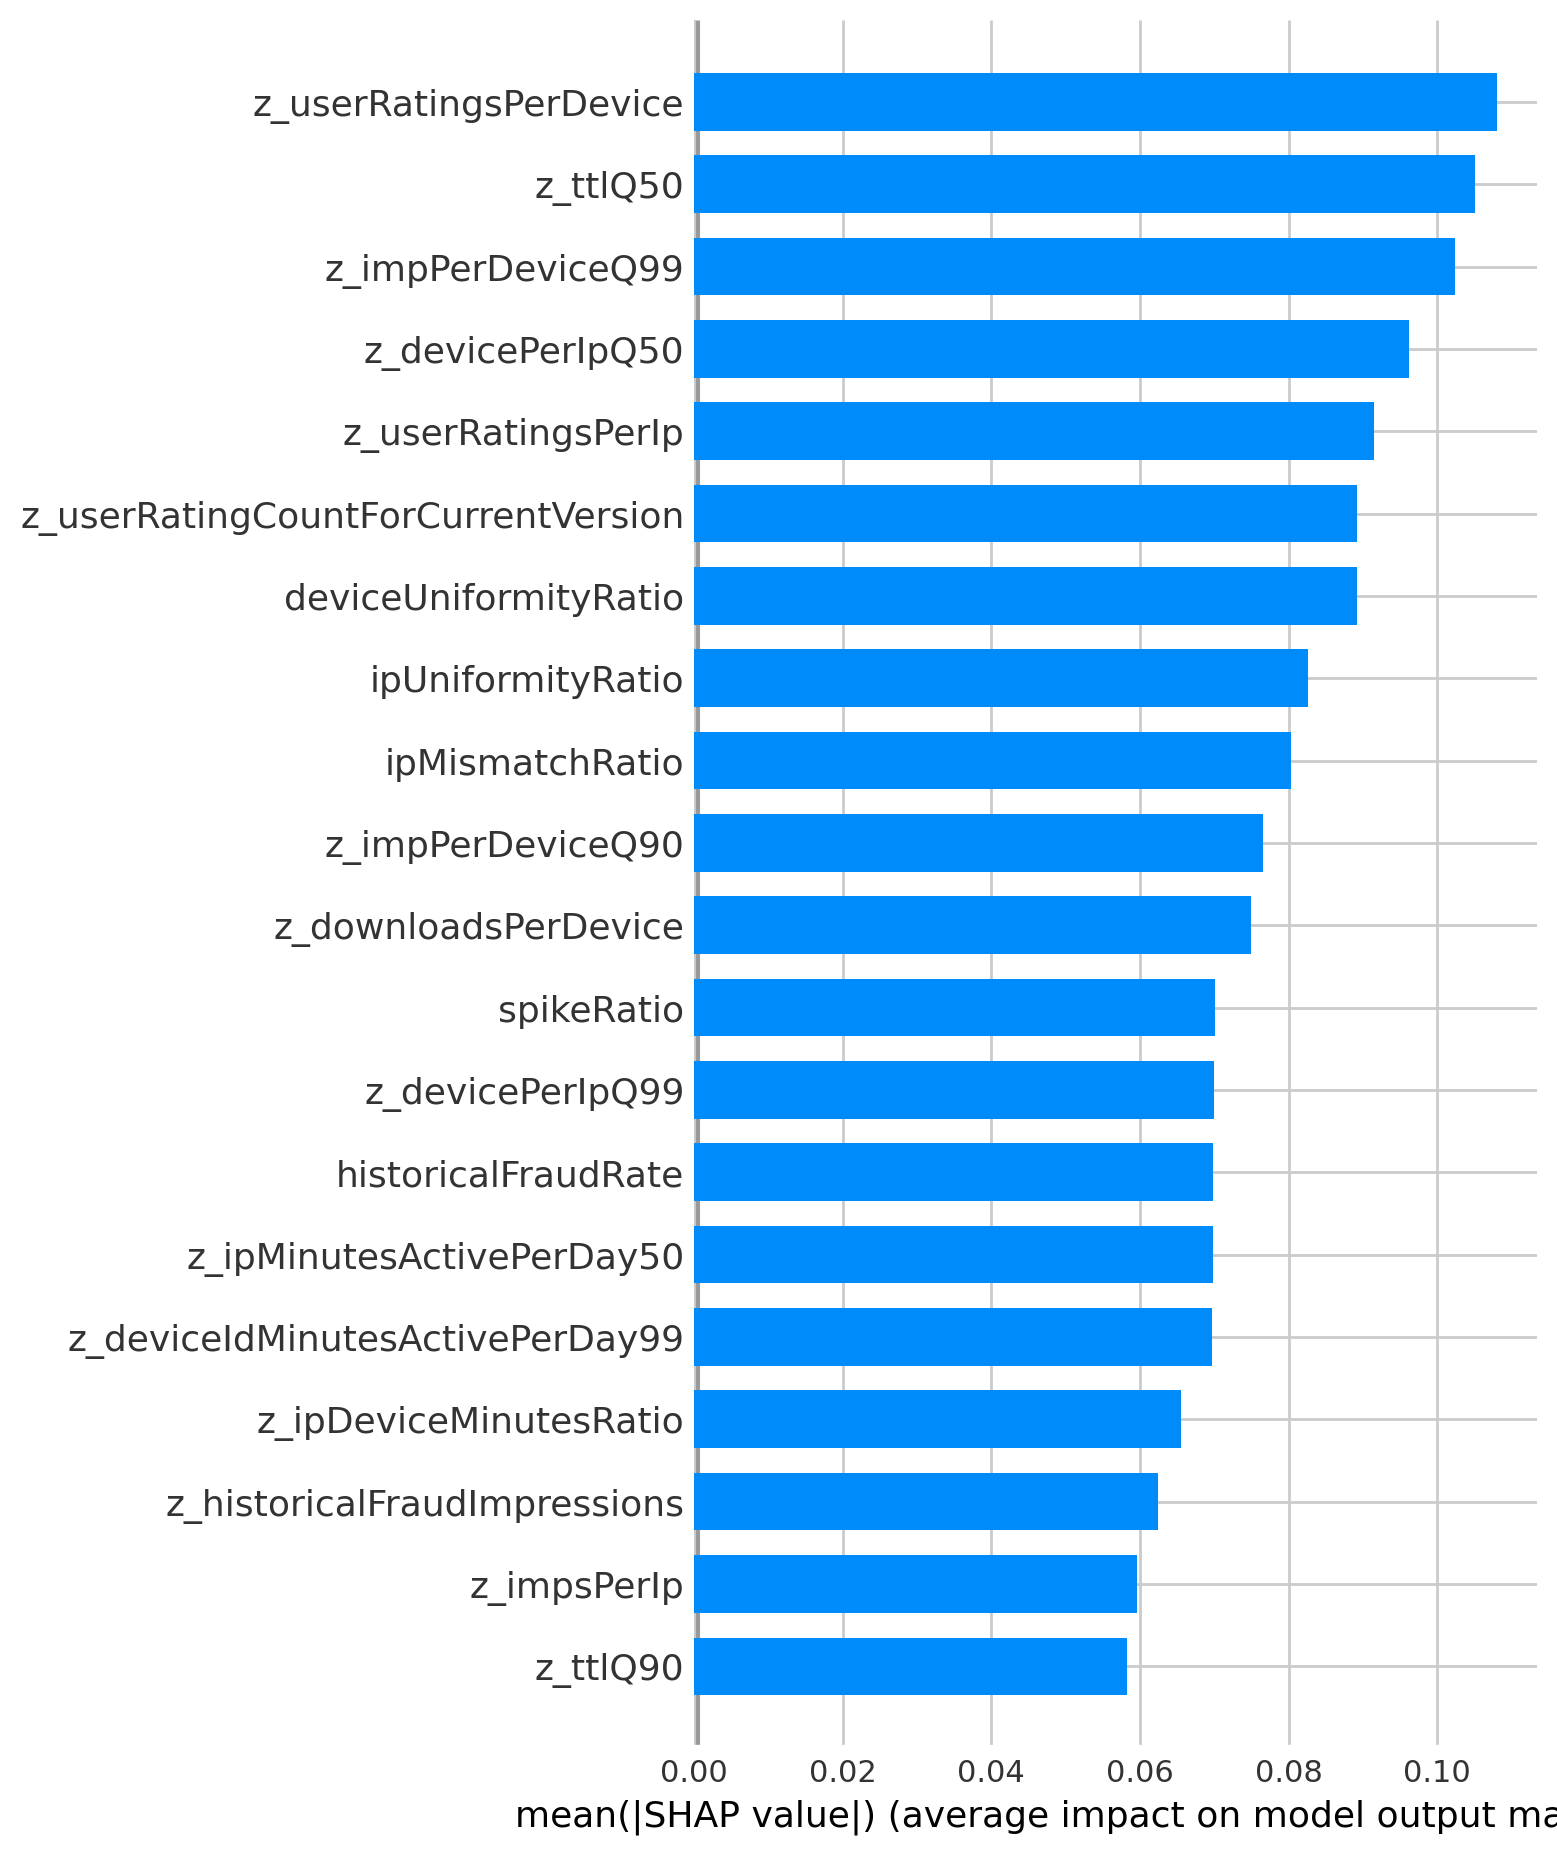

In [ ]:
# Visualise feature importance: summary plot
shap.summary_plot(
    shap_values,      # SHAP value matrix
    X,                # Data as a pandas DataFrame
    plot_type="bar",  # bar chart of mean(|SHAP value|)
    show=True
)

# Detailed summary: beeswarm plot
#    Each point is one sample; color = feature value
shap.summary_plot(
    shap_values,
    X,
    show=True
)

# 5 Report

In [ ]:
# # Create feature codes
# feature_codes = {feat: i for i, feat in enumerate(shap_df.columns, start=1)}

# # Invert to a df
# code_map_df = pd.DataFrame(
#     list(feature_codes.items()),
#     columns=['feature_name', 'reason_code']
# )

# # Re-order
# code_map_df = code_map_df[['reason_code', 'feature_name']]

# # Inspect
# # print(code_map_df)

In [ ]:
# # Compute values needed for min–max scaling
# all_scores = results['anomaly_score'].values
# sorted_scores = np.sort(all_scores)
# n_scores = len(sorted_scores)
# min_score = sorted_scores.min()
# max_score = sorted_scores.max()

# # Grab all outlier rows
# all_outliers = results[results['is_outlier']]

# # Prepare a list to store anomaly records
# anomaly_records = []

# # Iterate over each outlier row
# for idx, row in all_outliers.iterrows():
#     # Extract the SHAP values for this sample
#     sv = shap_df.loc[idx]
    
#     # Identify the top 3 features contributing to the anomaly (by absolute SHAP value)
#     top3 = sv.abs().nlargest(3).index.tolist()
#     f_top = top3[0]
    
#     # Build a human-readable reason string using top 3 features
#     reason = "; ".join(f"{feat}: {sv[feat]:.3f}" for feat in top3)
    
#     # Pick the top reason as reason code
#     reason_code = feature_codes[f_top]
    
#     # Min–max scaling of anomaly score into [0,1]
#     s_new = row['anomaly_score']
#     if max_score > min_score:
#         # Standard min–max
#         minmax_prob = (s_new - min_score) / (max_score - min_score)
#         minmax_prob = max(0.0, min(1.0, minmax_prob))
        
#         # Transformation: [0,1] → [0.5,1]
#         minmax_prob = minmax_prob / 2.0 + 0.5
#     else:
#         # No variation in scores → give the floor probability (50%)
#         minmax_prob = 0.5

#     # Append selected fields to the records list (removed importance_ratio, softmax, empirical_cdf)
#     anomaly_records.append({
#         'appId_osName'          : row['appId_osName'],
#         'anomaly_label'         : row['anomaly_label'],
#         'anomalyScore'          : s_new,
#         'totalImpressions'      : row['totalImpressions'],
#         'totalFraudImpressions' : row['totalFraudImpressions'],
#         'fraudRate'             : row['fraudRate'],
#         'reason_code'           : reason_code,
#         'reason'                : reason,
#         'minmax_prob'           : minmax_prob,
#     })

# # Convert the list of dicts into a DataFrame
# anomalies_df = pd.DataFrame(anomaly_records)

In [ ]:
# Generate feature codes
feature_codes = {feat: i for i, feat in enumerate(shap_df.columns, start=1)}
code_map_df = pd.DataFrame(
    list(feature_codes.items()),
    columns=['feature_name', 'reason_code']
)[['reason_code','feature_name']]

# Precompute min–max for anomaly_score → [0.5,1] probability
all_scores = results['anomaly_score'].values
min_score, max_score = all_scores.min(), all_scores.max()

# Focus on outliers
all_outliers = results[results['is_outlier']]

anomaly_records = []
for idx, row in all_outliers.iterrows():
    sv = shap_df.loc[idx]
    abs_sv = sv.abs()
    
    # top 3 contributors
    top_feats = abs_sv.nlargest(3).index.tolist()
    total_abs = abs_sv.sum() if abs_sv.sum() != 0 else 1.0

    # build verbose reason using feature names directly
    reasons = []
    for feat in top_feats:
        val = sv[feat]
        pct = abs(val) / total_abs
        reasons.append(
            f"{feat}: SHAP {val:.3f} ({pct:.1%} of impact)"
        )
    reason = " ; ".join(reasons)

    # pick top contributor code
    top_code = feature_codes[top_feats[0]]

    # scale to [0.5,1]
    raw = row['anomaly_score']
    if max_score > min_score:
        p = (raw - min_score) / (max_score - min_score)
        p = 0.5 + 0.5 * np.clip(p, 0.0, 1.0)
    else:
        p = 0.5

    anomaly_records.append({
        'appId_osName'          : row['appId_osName'],
        'anomaly_label'         : row['anomaly_label'],
        'anomalyScore'          : raw,
        'totalImpressions'      : row['totalImpressions'],
        'totalFraudImpressions' : row['totalFraudImpressions'],
        'fraudRate'             : row['fraudRate'],
        'reason_code'           : top_code,
        'reason'                : reason,
        'minmax_prob'           : p,
    })

anomalies_df = pd.DataFrame(anomaly_records)

In [ ]:
# Split on the last underscore, producing two new columns
anomalies_df[['appId_split', 'osName']] = (
    anomalies_df['appId_osName']
    .str.rsplit('_', n=1, expand=True)
)

# Rename the split-off column back to “appId”
anomalies_df = anomalies_df.rename(columns={'appId_split': 'appId'})

# Reorganized the columns
order = [
    'appId',
    'osName',
    'appId_osName',
    'anomaly_label',
    'anomalyScore',
    'reason_code',
    'reason',
    'minmax_prob',
    'totalImpressions',
    'totalFraudImpressions',
    'fraudRate',
]

# Reorder
anomalies_df = anomalies_df[order]

In [ ]:
anomalies_df.head()

## Saving to BQ

### Flagged Apps

In [ ]:
# Save anomalies_df to a csv file
client = 'all_clients'

anomalies_df.to_csv(f'flagged_apps/{client}_flagged_apps_{DATE}.csv', index=False)
print(f"Saved {client}_flagged_apps_{DATE}.csv")

In [ ]:
# Save full_report to BQ
save_df_to_bq(
    anomalies_df, 
    table_prefix="all_clients_flagged_apps", 
    date=DATE,
    project_id=PROJECT_ID,
    dataset=DESTINATION_DATASET,
)

### Full Report

In [ ]:
# 1) Merge anomalies_df onto df1 by 'appId'.
#    We use a left join so that every raw row remains, and anomaly columns become NaN for inliers.
full_report = anomalies_df.merge(
    df1,
    on='appId_osName',
    how='left'
)

# 2) Create a consistent boolean flag for outliers
#    If anomalyScore is non-null, it was flagged; otherwise it’s an inlier.
full_report['is_outlier'] = full_report['anomalyScore'].notna()

# 3) (Optional) Fill missing anomaly columns for inliers with defaults
#    e.g. 0 for scores and empty string for reason codes.
full_report['anomalyScore'] = full_report['anomalyScore'].fillna(0)
full_report['anomaly_label'] = full_report.get('anomaly_label', pd.Series()).fillna(1).astype(int)
full_report['reason_code'] = full_report['reason_code'].fillna('')
full_report['reason']      = full_report['reason'].fillna('')

# 4) Reorder columns if you like, e.g. put identifiers and anomaly info up front
cols = (
    ['appId', 'osName', 'appId_osName', 'is_outlier', 'anomalyScore', 'anomaly_label', 'reason_code', 'reason', 'minmax_prob']
    + [c for c in full_report.columns if c not in {'appId', 'appId', 'osName', 'appId_osName', 'is_outlier','anomalyScore','anomaly_label','reason_code','reason', 'minmax_prob'}]
)
full_report = full_report[cols]

In [ ]:
# Now `full_report` has all your original features plus the anomaly diagnostics.
display(full_report.head())

In [ ]:
# Save anomalies_df to a csv file
full_report.to_csv(f'full_report/{client}_full_report_{DATE}.csv', index=False)
print(f"Saved {client}_full_report_{DATE}.csv")

In [ ]:
# # Save full_report to BQ
# save_df_to_bq(
#     full_report, 
#     table_prefix="ss_full_report", 
#     date=DATE,
#     project_id=PROJECT_ID,
#     dataset=DESTINATION_DATASET,
# )

# 6 Correlation Analysis

In [ ]:
# 1) Select only numeric feature columns plus totalImpressions
cols = [c for c in results.columns if c not in ('appId', 'appId_osName', 'is_outlier', 'reason', 'reason_code')]
# 2) Compute correlations
corr_with_imps = results[cols].corr()['totalImpressions'] \
                           .drop('totalImpressions') \
                           .sort_values(ascending=False)

print(corr_with_imps)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 20))
corr_with_imps.plot(kind='barh')  # no need to specify colors
plt.xlabel('Pearson r with totalImpressions')
plt.title('Feature Correlation with App Size')
plt.gca().invert_yaxis()          # largest correlations on top
plt.tight_layout()
plt.show()